**A Brief Analysis of the Stack Overflow Data loaded as Google's BigQuery Dataset (Volume: 164.4 GB)**

In [1]:
import bq_helper
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from bq_helper import BigQueryHelper

stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="stackoverflow")

In [2]:
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")
bq_assistant.list_tables()

['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [3]:
bq_assistant.head("posts_questions", num_rows=5)

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,post_type_id,score,tags,view_count
0,47309613,Issue with the webpack-bundler,<p>I am trying to compile all my tsx files whi...,NaN,1,1,None,2017-11-15 14:11:29.557000+00:00,NaN,2017-11-15 14:23:45.703000+00:00,NaT,,NaN,,7614689,1,0,webpack,172
1,36953265,Reducing queries on Firebase,<p>I have the following problem:\nI have a lis...,NaN,0,3,None,2016-04-30 09:42:32.243000+00:00,NaN,2016-04-30 09:42:32.243000+00:00,NaT,,NaN,,5282695,1,0,javascript|firebase,40
2,35547622,Passing a Matrix from C++ to MATLAB,<p>I've reviewed questions with similar (almos...,NaN,0,7,None,2016-02-22 07:05:17.407000+00:00,NaN,2016-02-22 07:35:20.247000+00:00,2016-02-22 07:35:20.247000+00:00,,3855264.0,,3855264,1,1,c++|matlab|matrix,265
3,3474037,window.onload vs. body.onload vs. document.onr...,<p>What is the difference between <code>window...,3474078.0,1,5,None,2010-08-13 05:04:18.247000+00:00,14.0,2015-09-14 15:09:30.797000+00:00,2013-08-21 23:47:28.477000+00:00,,31671.0,,341144,1,73,javascript,65978
4,33749987,How to display two fragments vertically (maste...,<p>I'm trying to display information by select...,NaN,1,2,None,2015-11-17 05:46:14.160000+00:00,NaN,2015-11-17 06:38:25.550000+00:00,2015-11-17 06:38:25.550000+00:00,,4548981.0,,5548090,1,2,android|android-layout|listview|android-fragments,107


In [4]:
bq_assistant.head("posts_answers", num_rows=5)

,id,body,comment_count,community_owned_date,creation_date,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags
0,17147316,<p>Attach the <code>Mylocation.txt</code> as r...,1,None,2013-06-17 12:18:56.827000+00:00,2013-06-17 12:18:56.827000+00:00,None,,None,,1124244,17143806,2,0,
1,36356211,<p>Templates must ideally be implemented inlin...,0,None,2016-04-01 12:20:55.963000+00:00,2016-04-01 12:20:55.963000+00:00,None,,None,,264325,36356136,2,1,
2,29997584,<p>You can do it by creating a json encoded re...,4,None,2015-05-02 02:07:12.093000+00:00,2015-05-02 02:07:12.093000+00:00,None,,None,,987447,29997439,2,1,
3,15701054,"<p>The ""classical"" Java problem also affects m...",1,None,2013-03-29 10:01:10.730000+00:00,2013-03-29 10:01:10.730000+00:00,None,,None,,1016146,2598009,2,1,
4,468912,"<p>Another alternative, if you know the time b...",0,None,2009-01-22 12:24:51.253000+00:00,2009-01-22 12:24:51.253000+00:00,None,,None,xan,15667,468779,2,1,


In [5]:
bq_assistant.table_schema("posts_questions")

,name,type,mode,description
0,id,INTEGER,REQUIRED,None
1,title,STRING,NULLABLE,None
2,body,STRING,NULLABLE,None
3,accepted_answer_id,INTEGER,NULLABLE,None
4,answer_count,INTEGER,NULLABLE,None
5,comment_count,INTEGER,NULLABLE,None
6,community_owned_date,TIMESTAMP,NULLABLE,None
7,creation_date,TIMESTAMP,NULLABLE,None
8,favorite_count,INTEGER,NULLABLE,None
9,last_activity_date,TIMESTAMP,NULLABLE,None


What is the percentage of questions that have been answered over the years?


In [6]:
query1 = """SELECT
  EXTRACT(YEAR FROM creation_date) AS Year,
  COUNT(*) AS Number_of_Questions,
  ROUND(100 * SUM(IF(answer_count > 0, 1, 0)) / COUNT(*), 1) AS Percent_Questions_with_Answers
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
GROUP BY
  Year
HAVING
  Year > 2008 AND Year <= 2018
ORDER BY
  Year;
        """

Without running the query, the function "estimate_query_size" allows knowing that it would “cost” nearly 0.23 GB. 

In [7]:
bq_assistant.estimate_query_size(query1)

0.24422357976436615

The "query_to_pandas_safe" function makes the call to execute the query.

In [8]:
answered_questions = stackOverflow.query_to_pandas_safe(query1)
answered_questions.head(5)

,Year,Number_of_Questions,Percent_Questions_with_Answers
0,2009,343716,99.7
1,2010,694102,99.1
2,2011,1200071,97.2
3,2012,1644705,94.5
4,2013,2059303,91.6


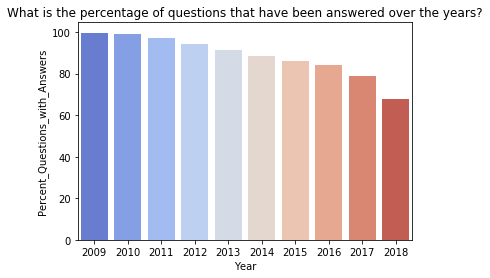

In [9]:
ax = sns.barplot(x="Year",y="Percent_Questions_with_Answers",data=answered_questions,palette="coolwarm").set_title("What is the percentage of questions that have been answered over the years?")

In [10]:
query1 = """SELECT
  EXTRACT(YEAR FROM creation_date) AS Year,
  COUNT(*) AS Number_of_Questions,
  SUM(IF(answer_count > 0, 1, 0)) AS Number_Questions_with_Answers
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
GROUP BY
  Year
HAVING
  Year > 2008 AND Year <= 2018
ORDER BY
  Year;
        """

answered_questions = stackOverflow.query_to_pandas_safe(query1)
answered_questions.head(5) 

,Year,Number_of_Questions,Number_Questions_with_Answers
0,2009,343716,342525
1,2010,694102,687582
2,2011,1200071,1165982
3,2012,1644705,1554607
4,2013,2059303,1885513


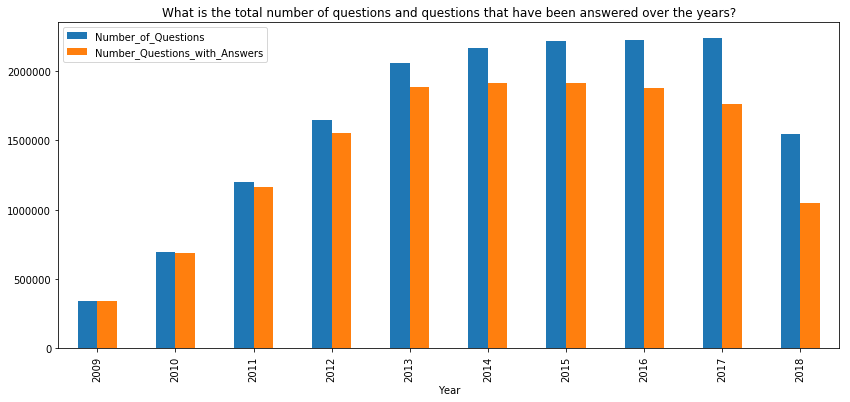

In [11]:
answered_questions.plot(x="Year",y=["Number_of_Questions","Number_Questions_with_Answers"], 

                    kind="bar",figsize=(14,6), 

                    title='What is the total number of questions and questions that have been answered over the years?')

What is the percentage of negatively scored questions over years?

In [12]:
query2 = """SELECT
  EXTRACT(YEAR FROM creation_date) AS Year,
  COUNT(*) AS Number_of_Questions,
  ROUND(100 * SUM(IF(score > 0, 1, 0)) / COUNT(*), 1) AS Percent_Questions_Scored_Negatively
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
GROUP BY
  Year
HAVING
  Year > 2008 AND Year <= 2018
ORDER BY
  Year;
        """
negatively_scored_questions = stackOverflow.query_to_pandas_safe(query2)
negatively_scored_questions.head(5)

,Year,Number_of_Questions,Percent_Questions_Scored_Negatively
0,2009,343716,73.0
1,2010,694102,70.1
2,2011,1200071,63.6
3,2012,1644705,58.6
4,2013,2059303,50.3


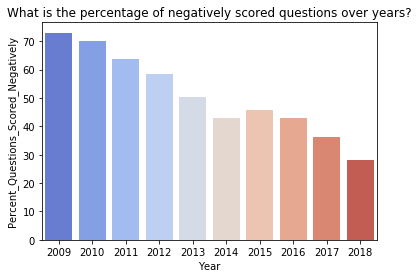

In [13]:
ax = sns.barplot(x="Year",y="Percent_Questions_Scored_Negatively",data=negatively_scored_questions,palette="coolwarm").set_title("What is the percentage of negatively scored questions over years?")

What is the number of questions about Apache Spark over years?

In [14]:
query3 = """SELECT 
    REGEXP_EXTRACT(tags, "spark") AS Tag, 
    EXTRACT(YEAR FROM creation_date) AS Year, 
    COUNT(*) AS Number_Spark_Questions
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
GROUP BY
  Tag, Year
HAVING
  Year > 2008 AND Year <= 2018 AND Tag IS NOT NULL
ORDER BY
  Year;
"""

bq_assistant.estimate_query_size(query3)

0.5346579430624843

In [15]:
spark_questions = stackOverflow.query_to_pandas_safe(query3)
spark_questions.head(5)

,Tag,Year,Number_Spark_Questions
0,spark,2009,63
1,spark,2010,145
2,spark,2011,253
3,spark,2012,215
4,spark,2013,239


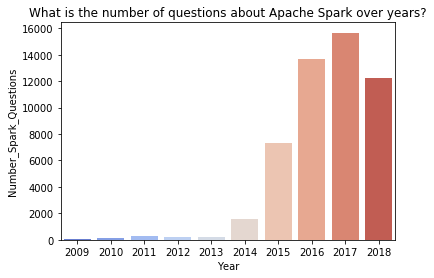

In [16]:
ax = sns.barplot(x="Year",y="Number_Spark_Questions",data=spark_questions,palette="coolwarm").set_title("What is the number of questions about Apache Spark over years?")

Which are the most typical tags used in questions?

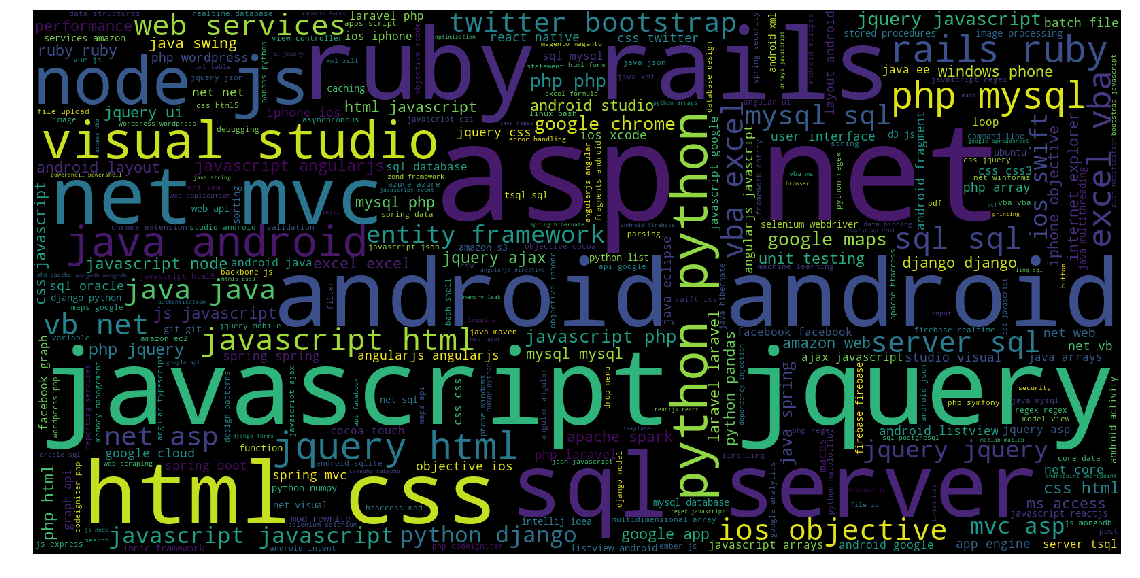

In [17]:
query4 = """SELECT tags
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
LIMIT 200000;
"""

alltags = stackOverflow.query_to_pandas_safe(query4)

tags = ' '.join(alltags.tags).lower()
cloud = wordcloud.WordCloud(background_color='black',
                            max_font_size=200,
                            width=1600,
                            height=800,
                            max_words=300,
                            relative_scaling=.5).generate(tags)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.savefig('stackOverflow.png')
plt.imshow(cloud);

How average score of answers is evolving over years?

In [18]:
query5 = """SELECT AVG(comment_count) AS Number_Comments, 
    score AS Score, 
    EXTRACT(YEAR FROM creation_date) AS Year
FROM 
    `bigquery-public-data.stackoverflow.posts_answers`
GROUP BY 
    Score, Year
ORDER BY
    Score;
"""

scores_answers = stackOverflow.query_to_pandas_safe(query5)
scores_answers.head(5)

,Number_Comments,Score,Year
0,6.0,-108,2011
1,7.0,-68,2009
2,11.0,-61,2014
3,11.0,-61,2010
4,11.0,-55,2008


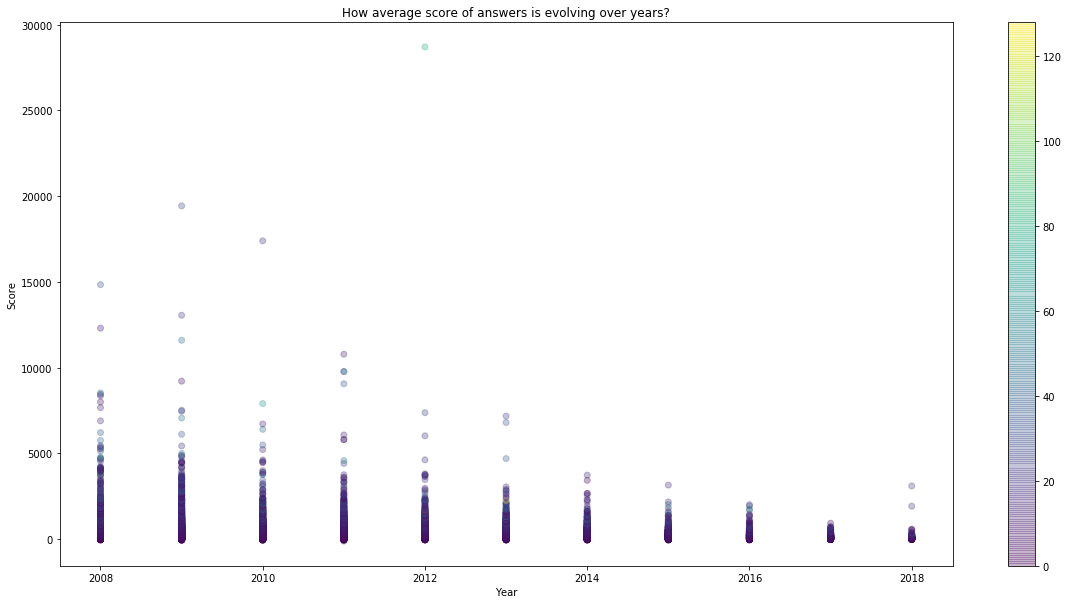

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(scores_answers["Year"], scores_answers["Score"], c=scores_answers["Number_Comments"], alpha=0.3, cmap='viridis')
plt.xlabel("Year")
plt.ylabel("Score")
plt.title("How average score of answers is evolving over years?")
plt.colorbar();  # show color scale